# Introduction

Up to this point, we have been satisfied with splitting the data into two sets, training and test, and reporting our predictive results on the test set. While this approach works, there are better ways to calculate and understand the test error of a model. We often judge model quality entirely on its ability to make accurate predictions on **unseen data**, so we should be sure that they represent the model's capabilities.

#Formulating the Problem

We know that when we split a dataset into **training and test sets**, we randomly split up the data as good practice. The randomization helps to ensure that the training set and the test set don't look too different from each other. That is, they both still come from the same population we're trying to predict on. While randomization usually helps with this, there can be times when it doesn't.

1. One way this randomness can hurt us is when it results in a **training and test set that are markedly different**. By virtue of how the data was randomized, we get a single test metric. How do we reconcile these differences in test error? What is the relationship between these test errors, if any?

1. **A second problem comes from the presence outliers**. As a mental exercise, imagine that we have a dataset with 100 observations, and we are doing an 80-20 split for a linear regression problem. Then, imagine that just one of these observations is an outlier that we cannot reasonably remove from the data. When we perform the split, the outlier will end up either in the training set or in the test set. In either of these cases, our model predictions are potentially harmed. This is because of the following:

  * If the outlier is in the training set, it can adversely affect the model estimates. Then, we'll get poor test predictions overall.
  
  * If the outlier is in the test set, our model estimates won't be affected, but we'll have one prediction for the outlier that might be extremely far from the actual observation because our model wasn't trained on similar data. This, in turn, inflates our test mean squared error.

Instead of using just one test error to judge the model, we can create a better picture of model performance by using **multiple training and test sets** using the original dataset and separate rounds of training. With multiple rounds of training comes multiple test errors, which we can examine to understand not only how well the model performs, but how well this performance varies.

 This is the core idea behind **K-fold cross-validation**, which we'll learn to incorporate into our machine learning workflow.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

housing = pd.read_csv("housing.csv")

mses = []
y = housing['median_income']
X = housing[['median_house_value','housing_median_age','total_rooms','population']]

for i in range(0,5): #from 0 to 4 inclusive
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=i)
    print(i)
    lm = LinearRegression()
    lm.fit(X_train,y_train)
    y_predict = lm.predict(X_test)
    mse= mean_squared_error(y_test,y_predict)
    mses.append(mse)

# Two-Fold Cross-Validation

Instead of relying on a single test score to understand model performance, we should actually look at the **distribution of these scores over different subsets of the data.**

We used random subsets on the previous exercise to divide our data. A more principled way to approach this would be to divide the entire dataset into evenly sized groups of observations **called folds.** Folds are equal, mutually exclusive divisions of the data. Let's visualize how a dataset might be divided into two folds:

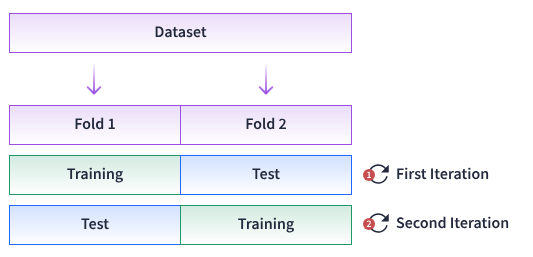

By dividing the data this way, each fold will be used for both training and testing purposes. This approach enables us to have two estimates for the test error — one for each iteration of training. We can take the average of these estimates to give us a better estimate of the predictive ability of the model. Even if an outlier causes one MSE to be higher than expected, taking the average will help balance this out.

This approach is called** two-fold cross-validation**. Cross-validation is an iterative process. We iterate over each fold and use it as the test set, using the other as the training set.

By doing this, each observation in the dataset has the chance to be used for both **training and testing.** This process is similar to the exercise on the previous screen, but it's more methodical because the data isn't being randomly chosen.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

housing = pd.read_csv("housing.csv")

y = housing["median_income"]
X = housing[["median_house_value", "housing_median_age", "total_rooms", "population"]]

#n_rows / 2
mid = int(housing.shape[0]/2)

#two folds cross-validation
model1 = LinearRegression()
model2 = LinearRegression()

#for the 1st fold
#train with first half
model1.fit(X[:mid],y[:mid])

#test with second half
y_predict1 = model1.predict(X[mid:])

#mse for the 1st fold
first_fold_test_mse = mean_squared_error(y[mid:],y_predict1)


#for the 2nd fold
#train with second half
model2.fit(X[mid:],y[mid:])

#test with first half
y_predict2 = model2.predict(X[:mid])

#mse for the 1st fold
second_fold_test_mse = mean_squared_error(y[:mid],y_predict2)

avg_mse = (first_fold_test_mse + second_fold_test_mse)/2


#K-Fold Cross-Validation

Now that we've manually implemented a quick two-fold cross-validation, we can move on to the more general form. Instead of using only two folds, we can choose an arbitrary number of folds, which leads us to **k-fold cross-validation**.

As before, the dataset will be divided into **k** folds of equal or approximately equal size. Then one fold will be used as the test set, while the remaining **(k-1)** folds will be used for the training set. With **k** folds, we'll also get k test MSEs, which means we can calculate not only their average but also their standard deviation. While **k** is generally considered arbitrary, a general rule is to use **k=5 or k=10**

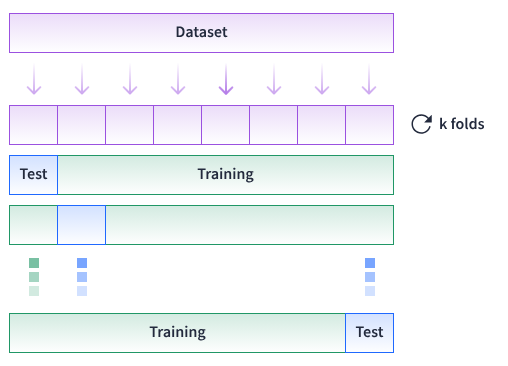

##K-Fold in SKLearn


We implement K-fold cross-validation with the `cross_val_score() `function, which is contained in the model_selection module. Although the `cross_val_score()` function has many arguments, we'll cover the five main ones you should know:

  * `estimator`: this should be a model that we want to perform cross-validation on, like `LinearRegression` or `LogisticRegression`. The model doesn't need to be fit to data, just instantiated from the class.

  * `X`: this is the predictor variable(s) that we'd like to use in the model.

  * `y`: this is the outcome of interest

  * `cv`: this corresponds to **how many folds** we want to use in the cross-validation. While this already defaults to 5, it's good to know just in case you'd like to change it.

  * `scoring`: this corresponds to the metric that we should use to judge the model. This is important because we might be interested in other types of metrics other than the default for the model.


    from sklearn.model_selection import cross_val_score
    from linear_model import LinearRegression

    model = LinearRegression()
    fold_mses = cross_val_score(model, X, y, cv=5, scoring="neg_mean_squared_error")

The output of `cross_val_score() `is an array containing all of the test scores. The default score function for LinearRegression is actually **R²**, not the mean squared error. To use MSE, we needed to indicate this with the `scoring` parameter.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


housing = pd.read_csv("housing.csv")

y = housing["median_income"]
X = housing[["median_house_value", "housing_median_age", "total_rooms", "population"]]

#fist create the linear model
model = LinearRegression()

#instantiate cross_val object
housing_cv = cross_val_score(model, X, y, cv=5, scoring="neg_mean_squared_error")

#the model return an array of scores

#mean of scores
cv_avg = housing_cv.mean()

#standard deviation of scores
cv_std = housing_cv.std()


# Leave One Out Cross-Validation

In the beginning, we started with just one training and test set provided by train_test_split(). Then, we used k-fold cross-validation to create multiple test sets that were based on different folds of the data. Rather than choosing a small number of folds like two or five, what if we go to the extreme and take
**k=n**, where **n** is the number of observations in the data. Then, each observation itself is a fold!

This is **Leave One Out Cross-Validation (LOOCV)**. Leave One Out Cross-Validation has the benefit of enabling models to be trained on as much data as possible. However, it has considerable downsides.

1. First, there's a computational cost since we have to train **n** models.

1. Second, calculating a test error based on a single observation can produce wildly fluctuating results.

We mentioned that **k=5 or k=10** is a satisfactory number of folds to use, so why mention LOOCV? It brings up a common issue in machine learning, which we'll explore on the next screen. Rather than immediately describe what this issue is, it's good to see how it can show up even in toy machine learning problems.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

housing = pd.read_csv("housing.csv")

y = housing["median_income"]
X = housing[["median_house_value", "housing_median_age", "total_rooms", "population"]]

model = LinearRegression()



#instantiate cross_val object

#2 folds
k2 = cross_val_score(model, X, y, cv=2, scoring="neg_mean_squared_error")

#10 fold
k10 = cross_val_score(model, X, y, cv=10, scoring="neg_mean_squared_error")

#100 folds
k100 = cross_val_score(model, X, y, cv=100, scoring="neg_mean_squared_error")

avgs = [k2.mean(), k10.mean(), k100.mean()]

stds = [k2.std(), k10.std(), k100.std()]

#Conclusion

Between the extremes of LOOCV and two-fold cross-validation, we saw on the previous screen that:
1. K-fold ++++ -> stds tests errors ++++

1. K-fold ++ -> avg tests errors -- gives us a more accurate estimate of what it might be when used on unseen data.

In other words, increasing the number of folds **reduces the bias** of the average test error, but it increases their variance. With a small number of folds, these trends are reversed.

K-fold cross-validation comes with one form of the bias-variance tradeoff. There are several forms of bias-variance tradeoff in machine learning, but this particular one involves the test error. Ideally, we'd like to strike a balance between minimizing the bias (because we want to know in general how well the model will perform) and minimizing the variance of the test errors (because we want to know how our error might vary with different datasets). Researchers have performed numerical simulations and found that k=5 or k=10 produce this desired balance.